In [12]:
#import os
#import glob
#import numpy as np
#import enchant
#import matplotlib.pylab as plt
import nltk
from nltk.corpus import stopwords
#import spacy
#import math
#import seaborn as sns
#from itertools import chain
#from wordcloud import WordCloud
import sqlite3
import pandas as pd


In [12]:
import pdftotext

with open("../rsc/wahlprogramme/afd_de.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)

## If it's password-protected
#with open("secure.pdf", "rb") as f:
#    pdf = pdftotext.PDF(f, "secret")

# Read all the text into one string
afd_wp = "\n\n".join(pdf)
print(afd_wp)

PROGRAMM FÜR
DEUTSCHLAND
Wahlprogramm der Alternative für Deutschland
für die Wahl zum Deutschen Bundestag
am 24. September 2017
Beschlossen auf dem Bundesparteitag in Köln am 22./23. April 2017
www.afd.de/wahlprogramm




Wahlprogramm Bundestagswahl 2017 | Inhalt                                                                                                  3
1 | Verteidigung der Demokratie in Deutschland                     06 3 | Außen- und Sicherheitspolitik:
                                                                          Deutsche Interessen durchsetzen			                            17
  1.1    Ohne Volkssouveränität keine Demokratie 		                07
  1.2    Zurückführung der Europäischen Union in einen                  3.1   Außenpolitik muss sich an deutschen Interessen ausrichten 18
		       Staatenbund souveräner Staaten 			                        07   3.2   Das Verhältnis zu wichtigen Staaten ändert sich           18
  1.3    Das Volk muss wieder zum Souverän w

In [13]:
# Nice party colors
parties = ['linke', 'spd', 'grüne', 'cdu', 'fdp', 'afd']
colors = {'linke': '#dc0000ff',
          'grüne': '#42923bff',
          'spd': '#e2001aff',
          'cdu': '#252422ff',
          'fdp': '#ffec01ff',
          'afd': '#009ee0ff'}


In [ ]:
bt_election = time.strptime('24.09.2017', "%d.%m.%Y")
eu_election = time.strptime('26.05.2019', "%d.%m.%Y")

bt_start = bt_election - timedelta(days=90)
eu_start = eu_election - timedelta(days=90)

In [14]:
# Load data
conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)
data.set_index('videoId', inplace=True)

bt_raw = {party: data[data['party'] == party]['subtitle'].str.cat(sep=' ') for party in parties}
eu_raw = {party: data[data['party'] == party]['subtitle'].str.cat(sep=' ') for party in parties}

In [ ]:
# Dictionary filtering
dic = enchant.Dict("de_DE")
dic_filtered = {party: (word.capitalize() for word in raws[party].split() if not dic.check(word.lower()) and word.isalpha()) for party in parties}

In [ ]:
# Stemming and lemmatization
nlp = spacy.load('de', disable=['parser', 'ner', 'tagger'])
nlp.max_length = 30_000_000

normalized = {party: (nlp(word)[0]
                      for word in dic_filtered[party]) for party in parties}

In [ ]:
# Stop words removal
stop = set(stopwords.words('german'))

custom_stop = ["dass", "sagen", "mal", "ganz", "ja", "all", "immer",
               "müssen", "schon", "geben", "gut", "deshalb", "brauchen", "damen", "herren"]
corpus = {party: [w.lemma_ for w in normalized[party]
                  if w.lemma_ not in stop
                  and w.lemma_ not in custom_stop
                  and len(w.lemma_) > 3
                  and w.is_alpha]
          for party in parties}

<BarContainer object of 6 artists>

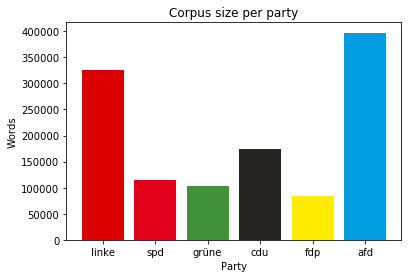

In [17]:
# Corpus size
plt.figure()
plt.ylabel("Words")
plt.xlabel("Party")
plt.title("Corpus size per party")
plt.bar(parties,
        [len(corpus[key]) for key in parties],
        color=[colors[key] for key in parties])

In [18]:
def tfidf(fdists, name):
    """Term frequency - inverse document frequency."""

    def tf(token, fdist):
        return 0.5 + (0.5 * fdist.get(token))/fdist.most_common(1)[0][1]

    def idf(token):
        return math.log2(len(corpus)/(sum(1 for key in fdists.keys() if fdists.get(key).get(token) is not None)))
    fdist = fdists.get(name)
    return [(token, tf(token, fdist) * idf(token)) for token in fdist.keys()]


In [19]:
# Word frequency
fdists = {party: nltk.FreqDist(
    [w for w in corpus[party] if dic.check(w)]) for party in parties}
# for party in parties:
#     fdist = fdists[party]
#     plt.figure()
#     fdist.plot(20)

# TF-IDF
tfidfs = {party: tfidf(fdists, party) for party in parties}
my_weights = {party: my_weighting(fdists, party) for party in parties}

NameError: name 'my_weighting' is not defined

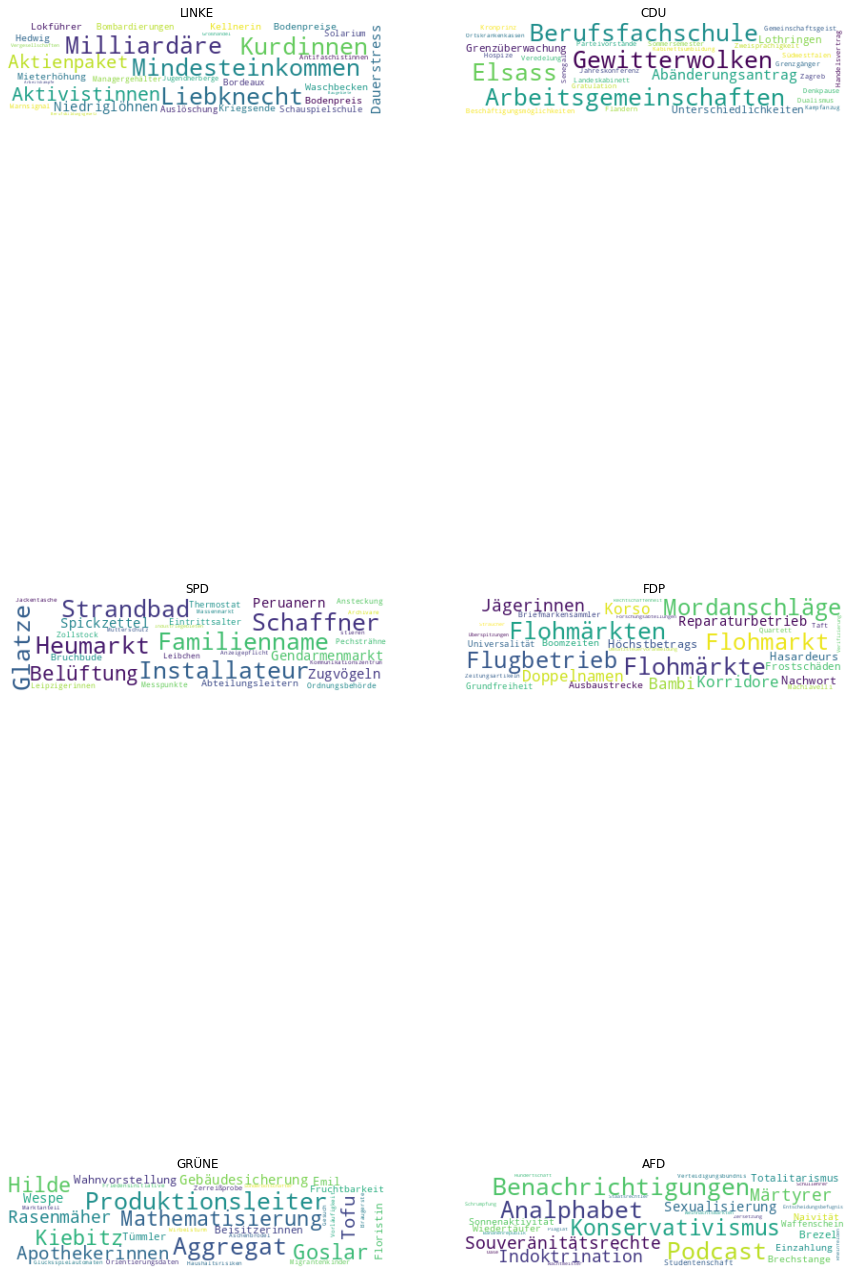

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(15, 30))
axis = chain.from_iterable(zip(*axs))
for party, ax in zip(parties, axis):
    ax.axis("off")
    ax.set_title(party.upper())
    word_weights = sorted(
        tfidfs[party], reverse=True, key=lambda x: x[1])[:30]
    wordcloud = WordCloud(background_color='white', max_font_size=25, height=100).generate_from_frequencies(
        dict(word_weights))
    ax.imshow(wordcloud, interpolation='bilinear')


